# Training prediction models (per recipe)

Use pre-trained DenseNet121 model as backbone model.

Add Imagenet preprocessing to the first layer

Five models: calorie, calorie+ingredient, calorie+category, calorie+nutrient, calorie+3 vectors

In [ ]:
import ast
import pickle
import pandas as pd

In [1]:
from tensorflow import config

gpu_devices = config.experimental.list_physical_devices('GPU')

for device in gpu_devices: config.experimental.set_memory_growth(device, True)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0 2"

## Load preprocessed csv file

In [2]:
train_data = pd.read_csv('./data/train_per_recipe_complete.csv')

# transform format from string to list 
train_data['category_vector'] = train_data['category_vector'].apply(ast.literal_eval)
train_data['nutrient_vector'] = train_data['nutrient_vector'].apply(ast.literal_eval)
train_data['ingredient_vector'] = train_data['ingredient_vector'].apply(ast.literal_eval)

print(len(train_data))
train_data.head()

5422


,title,image,ingredients,nutrients,file_name,category,serving,url,source,calorie,calorie_per_recipe,category_vector,parsed_ingredients,ingredient_vector,nutrient_vector
0,Easy bread rolls,https://images.immediate.co.uk/production/vola...,"['500g strong white bread flour , plus extra f...","{'calories': '246 calories', 'fatContent': '2 ...",bread0.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Easy-bread...,bbc,246,1968.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['bread flour', 'action yeast', 'caster sugar'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[16.0, 384.0, 64.0]"
1,Vegan banana bread,https://images.immediate.co.uk/production/vola...,"['3 large black bananas', '75ml vegetable oil ...","{'calories': '218 calories', 'fatContent': '8 ...",bread1.jpg,bread,10.0,https://www.bbcgoodfood.com/recipes/Vegan-bana...,bbc,218,2180.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['black banana', 'sunflower oil', 'brown sugar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[80.0, 330.0, 30.0]"
2,Meatball & garlic bread traybake,https://images.immediate.co.uk/production/vola...,"['350g turkey thigh mince', '1 tsp dried orega...","{'calories': '565 calories', 'fatContent': '28...",bread2.jpg,bread,3.0,https://www.bbcgoodfood.com/recipes/Meatball-&...,bbc,565,1695.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['thigh mince', 'tsp oregano', 'fennel seed', ...","[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[84.0, 102.0, 126.0]"
3,Naan bread,https://images.immediate.co.uk/production/vola...,"['1x 7g sachet dried yeast', '2 tsp golden cas...","{'calories': '224 calories', 'fatContent': '8 ...",bread3.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Naan-bread,bbc,224,1792.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['sachet yeast', 'caster sugar', 'bread flour'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[64.0, 248.0, 48.0]"
4,Pitta bread,https://images.immediate.co.uk/production/vola...,"['2 tsp fast-action dried yeast', '500g strong...","{'calories': '246 calories', 'fatContent': '2 ...",bread4.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Pitta-bread,bbc,246,1968.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['fastaction yeast', 'bread flour', 'tsp salt'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[16.0, 376.0, 64.0]"


## Build network

Add imagenet preprocessing as the first layer.

use Densenet121 as the backbone model.

define multi-outputs with corresponding activation functions to help improve the accurcy of calorie(y).

In [3]:
# do not mix tensorflow and keras...
# https://stackoverflow.com/questions/51821537/attributeerror-node-object-has-no-attribute-output-masks


import tensorflow as tf

i = tf.keras.layers.Input([256, 256, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.densenet.preprocess_input(x)
core = tf.keras.applications.densenet.DenseNet121(weights='imagenet', include_top=False)

x = core(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation = "relu", name='calorie')(x)
y1 = tf.keras.layers.Dense(12, activation = "softmax", name='category_vector')(x)
y2 = tf.keras.layers.Dense(3, activation = "relu", name='nutrient_vector')(x)
y3 = tf.keras.layers.Dense(100, activation = "sigmoid", name='ingredient_vector')(x)

model = tf.keras.models.Model(inputs=[i], outputs=[y, y1, y2, y3])

for l in model.layers:
    l.trainable = False
for l in model.layers[-7:]:
    l.trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 256, 256, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 256, 256, 3) 0           tf_op_layer_Cast[0][0]           
__________________________________________________________________________________________________
tf_op_layer_BiasAdd (TensorFlow [(None, 256, 256, 3) 0           tf_op_layer_truediv[0][0]        
______________________________________________________________________________________________

## Train multi-task models (per recipe)

### 5. output: calorie + three vectors

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'category_vector', 'nutrient_vector', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'category_vector', 'nutrient_vector', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

Found 4333 validated image filenames.
Found 1083 validated image filenames.


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'ingredient_vector':'binary_crossentropy', 
                                             'category_vector':'categorical_crossentropy', 'nutrient_vector':'mse'}
                                              , metrics=['mse'])

 
checkpointer = ModelCheckpoint(filepath='./multi-output/recipe_three_vector_100epoch.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   ) 


with open('./multi-output/recipe_three_vector_100epoch.pkl','wb') as f:
    pickle.dump(history.history, f) 

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 34 steps, validate for 8 steps
Epoch 1/100
22/34 [==================>...........] - ETA: 31s - loss: 2372024.2784 - calorie_loss: 2359787.7500 - category_vector_loss: 4.8052 - nutrient_vector_loss: 12230.8447 - ingredient_vector_loss: 0.5777 - calorie_mse: 2358423.5000 - category_vector_mse: 0.1019 - nutrient_vector_mse: 12216.0215 - ingredient_vector_mse: 0.1403

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/34 [============================>.] - ETA: 2s - loss: 2284408.3295 - calorie_loss: 2268710.2500 - category_vector_loss: 6.2619 - nutrient_vector_loss: 15690.9697 - ingredient_vector_loss: 0.5952 - calorie_mse: 2267391.2500 - category_vector_mse: 0.1094 - nutrient_vector_mse: 15696.7441 - ingredient_vector_mse: 0.1171
Epoch 00001: val_calorie_loss improved from inf to 2528235.25000, saving model to ./multi-output/recipe_three_vector_100epoch.h5
34/34 [==============================] - 104s 3s/step - loss: 2268644.2318 - calorie_loss: 2253274.0000 - category_vector_loss: 6.4079 - nutrient_vector_loss: 15401.6191 - ingredient_vector_loss: 0.5989 - calorie_mse: 2251926.0000 - category_vector_mse: 0.1099 - nutrient_vector_mse: 15405.9541 - ingredient_vector_mse: 0.1160 - val_loss: 2536606.8750 - val_calorie_loss: 2528235.2500 - val_category_vector_loss: 10.8528 - val_nutrient_vector_loss: 8360.1836 - val_ingredient_vector_loss: 0.4049 - val_calorie_mse: 2528235.2500 - val_category_vector

Epoch 9/100
33/34 [============================>.] - ETA: 2s - loss: 548451.4157 - calorie_loss: 538012.0000 - category_vector_loss: 16.9036 - nutrient_vector_loss: 10421.4395 - ingredient_vector_loss: 1.0486 - calorie_mse: 538393.2500 - category_vector_mse: 0.1302 - nutrient_vector_mse: 10443.6113 - ingredient_vector_mse: 0.0819
Epoch 00009: val_calorie_loss improved from 714919.87500 to 708325.37500, saving model to ./multi-output/recipe_three_vector_100epoch.h5
34/34 [==============================] - 97s 3s/step - loss: 548903.8713 - calorie_loss: 538607.1875 - category_vector_loss: 16.8865 - nutrient_vector_loss: 10267.5117 - ingredient_vector_loss: 1.0474 - calorie_mse: 538979.8125 - category_vector_mse: 0.1301 - nutrient_vector_mse: 10288.3535 - ingredient_vector_mse: 0.0819 - val_loss: 714981.4297 - val_calorie_loss: 708325.3750 - val_category_vector_loss: 24.2329 - val_nutrient_vector_loss: 6631.2622 - val_ingredient_vector_loss: 0.6254 - val_calorie_mse: 708325.3750 - val_cat

Epoch 17/100
33/34 [============================>.] - ETA: 2s - loss: 534622.2027 - calorie_loss: 524435.0000 - category_vector_loss: 5.4188 - nutrient_vector_loss: 10181.3740 - ingredient_vector_loss: 0.3677 - calorie_mse: 524789.6250 - category_vector_mse: 0.0975 - nutrient_vector_mse: 10205.6758 - ingredient_vector_mse: 0.0595
Epoch 00017: val_calorie_loss improved from 666762.87500 to 653464.62500, saving model to ./multi-output/recipe_three_vector_100epoch.h5
34/34 [==============================] - 91s 3s/step - loss: 535751.8141 - calorie_loss: 525694.2500 - category_vector_loss: 5.4030 - nutrient_vector_loss: 10041.1299 - ingredient_vector_loss: 0.3671 - calorie_mse: 526043.8750 - category_vector_mse: 0.0974 - nutrient_vector_mse: 10064.0986 - ingredient_vector_mse: 0.0595 - val_loss: 659583.8516 - val_calorie_loss: 653464.6250 - val_category_vector_loss: 15.1773 - val_nutrient_vector_loss: 6103.8203 - val_ingredient_vector_loss: 0.2839 - val_calorie_mse: 653464.6250 - val_cate

Epoch 25/100
33/34 [============================>.] - ETA: 2s - loss: 520521.2689 - calorie_loss: 510511.5625 - category_vector_loss: 2.7581 - nutrient_vector_loss: 10006.7627 - ingredient_vector_loss: 0.2166 - calorie_mse: 510966.8750 - category_vector_mse: 0.0767 - nutrient_vector_mse: 10030.7520 - ingredient_vector_mse: 0.0491
Epoch 00025: val_calorie_loss improved from 614392.56250 to 607373.25000, saving model to ./multi-output/recipe_three_vector_100epoch.h5
34/34 [==============================] - 91s 3s/step - loss: 520375.9261 - calorie_loss: 510494.8750 - category_vector_loss: 2.7658 - nutrient_vector_loss: 9864.8164 - ingredient_vector_loss: 0.2167 - calorie_mse: 510936.6562 - category_vector_mse: 0.0767 - nutrient_vector_mse: 9887.4746 - ingredient_vector_mse: 0.0491 - val_loss: 613568.0078 - val_calorie_loss: 607373.2500 - val_category_vector_loss: 10.8307 - val_nutrient_vector_loss: 6183.7637 - val_ingredient_vector_loss: 0.1955 - val_calorie_mse: 607373.2500 - val_catego

Epoch 33/100
33/34 [============================>.] - ETA: 2s - loss: 501311.5994 - calorie_loss: 491392.4688 - category_vector_loss: 2.5120 - nutrient_vector_loss: 9916.3877 - ingredient_vector_loss: 0.2045 - calorie_mse: 491782.1250 - category_vector_mse: 0.0755 - nutrient_vector_mse: 9940.7891 - ingredient_vector_mse: 0.0476  
Epoch 00033: val_calorie_loss improved from 562161.37500 to 559593.43750, saving model to ./multi-output/recipe_three_vector_100epoch.h5
34/34 [==============================] - 90s 3s/step - loss: 500961.8985 - calorie_loss: 491191.9688 - category_vector_loss: 2.5112 - nutrient_vector_loss: 9755.7451 - ingredient_vector_loss: 0.2049 - calorie_mse: 491569.2500 - category_vector_mse: 0.0755 - nutrient_vector_mse: 9778.7227 - ingredient_vector_mse: 0.0478 - val_loss: 565484.5547 - val_calorie_loss: 559593.4375 - val_category_vector_loss: 5.1134 - val_nutrient_vector_loss: 5885.7871 - val_ingredient_vector_loss: 0.1967 - val_calorie_mse: 559593.4375 - val_categor

Epoch 41/100
33/34 [============================>.] - ETA: 2s - loss: 497685.0142 - calorie_loss: 487849.6875 - category_vector_loss: 2.3282 - nutrient_vector_loss: 9832.7471 - ingredient_vector_loss: 0.2008 - calorie_mse: 488403.8125 - category_vector_mse: 0.0738 - nutrient_vector_mse: 9858.0596 - ingredient_vector_mse: 0.0475  
Epoch 00041: val_calorie_loss did not improve from 531118.12500
34/34 [==============================] - 90s 3s/step - loss: 497576.4083 - calorie_loss: 487881.3750 - category_vector_loss: 2.3272 - nutrient_vector_loss: 9676.4209 - ingredient_vector_loss: 0.2010 - calorie_mse: 488419.2500 - category_vector_mse: 0.0738 - nutrient_vector_mse: 9700.2998 - ingredient_vector_mse: 0.0475 - val_loss: 538736.6758 - val_calorie_loss: 532944.7500 - val_category_vector_loss: 4.7831 - val_nutrient_vector_loss: 5786.9189 - val_ingredient_vector_loss: 0.1846 - val_calorie_mse: 532944.7500 - val_category_vector_mse: 0.0929 - val_nutrient_vector_mse: 5786.9189 - val_ingredien

Epoch 49/100
33/34 [============================>.] - ETA: 2s - loss: 493371.3920 - calorie_loss: 483500.1562 - category_vector_loss: 2.3290 - nutrient_vector_loss: 9868.8008 - ingredient_vector_loss: 0.2011 - calorie_mse: 483983.3750 - category_vector_mse: 0.0734 - nutrient_vector_mse: 9894.3281 - ingredient_vector_mse: 0.0475  
Epoch 00049: val_calorie_loss improved from 515486.31250 to 512990.75000, saving model to ./multi-output/recipe_three_vector_100epoch.h5
34/34 [==============================] - 90s 3s/step - loss: 491292.8567 - calorie_loss: 481591.2500 - category_vector_loss: 2.3285 - nutrient_vector_loss: 9685.3506 - ingredient_vector_loss: 0.2012 - calorie_mse: 482051.7812 - category_vector_mse: 0.0734 - nutrient_vector_mse: 9709.3184 - ingredient_vector_mse: 0.0475 - val_loss: 518774.0742 - val_calorie_loss: 512990.7500 - val_category_vector_loss: 4.1781 - val_nutrient_vector_loss: 5778.9199 - val_ingredient_vector_loss: 0.1904 - val_calorie_mse: 512990.7500 - val_categor

Epoch 57/100
33/34 [============================>.] - ETA: 2s - loss: 483985.7386 - calorie_loss: 474245.4688 - category_vector_loss: 2.3242 - nutrient_vector_loss: 9737.7363 - ingredient_vector_loss: 0.1981 - calorie_mse: 474695.7188 - category_vector_mse: 0.0742 - nutrient_vector_mse: 9763.3555 - ingredient_vector_mse: 0.0471
Epoch 00057: val_calorie_loss did not improve from 509497.43750
34/34 [==============================] - 90s 3s/step - loss: 484707.8709 - calorie_loss: 475060.0312 - category_vector_loss: 2.3269 - nutrient_vector_loss: 9632.0107 - ingredient_vector_loss: 0.1983 - calorie_mse: 475500.5625 - category_vector_mse: 0.0742 - nutrient_vector_mse: 9656.4092 - ingredient_vector_mse: 0.0471 - val_loss: 518342.6250 - val_calorie_loss: 512579.5000 - val_category_vector_loss: 3.8303 - val_nutrient_vector_loss: 5759.1318 - val_ingredient_vector_loss: 0.1873 - val_calorie_mse: 512579.5000 - val_category_vector_mse: 0.0863 - val_nutrient_vector_mse: 5759.1318 - val_ingredient_

Epoch 65/100
33/34 [============================>.] - ETA: 2s - loss: 479588.0407 - calorie_loss: 469816.1875 - category_vector_loss: 2.2538 - nutrient_vector_loss: 9769.4883 - ingredient_vector_loss: 0.1976 - calorie_mse: 470357.5312 - category_vector_mse: 0.0729 - nutrient_vector_mse: 9795.6934 - ingredient_vector_mse: 0.0471
Epoch 00065: val_calorie_loss did not improve from 507471.25000
34/34 [==============================] - 90s 3s/step - loss: 479746.2305 - calorie_loss: 470108.2188 - category_vector_loss: 2.2525 - nutrient_vector_loss: 9619.8848 - ingredient_vector_loss: 0.1977 - calorie_mse: 470634.8438 - category_vector_mse: 0.0729 - nutrient_vector_mse: 9644.6602 - ingredient_vector_mse: 0.0471 - val_loss: 516009.2969 - val_calorie_loss: 510228.5625 - val_category_vector_loss: 3.3046 - val_nutrient_vector_loss: 5777.1763 - val_ingredient_vector_loss: 0.1845 - val_calorie_mse: 510228.5625 - val_category_vector_mse: 0.0823 - val_nutrient_vector_mse: 5777.1763 - val_ingredient_

Epoch 73/100
33/34 [============================>.] - ETA: 2s - loss: 473843.3239 - calorie_loss: 464104.0625 - category_vector_loss: 2.2578 - nutrient_vector_loss: 9736.7705 - ingredient_vector_loss: 0.1967 - calorie_mse: 464610.3438 - category_vector_mse: 0.0728 - nutrient_vector_mse: 9762.2461 - ingredient_vector_mse: 0.0471
Epoch 00073: val_calorie_loss did not improve from 498569.59375
34/34 [==============================] - 90s 3s/step - loss: 475447.9845 - calorie_loss: 465839.9375 - category_vector_loss: 2.2588 - nutrient_vector_loss: 9590.5957 - ingredient_vector_loss: 0.1965 - calorie_mse: 466338.8750 - category_vector_mse: 0.0729 - nutrient_vector_mse: 9614.6768 - ingredient_vector_mse: 0.0471 - val_loss: 510384.6719 - val_calorie_loss: 504659.6875 - val_category_vector_loss: 3.4036 - val_nutrient_vector_loss: 5721.3901 - val_ingredient_vector_loss: 0.1801 - val_calorie_mse: 504659.6875 - val_category_vector_mse: 0.0833 - val_nutrient_vector_mse: 5721.3901 - val_ingredient_

33/34 [============================>.] - ETA: 2s - loss: 470636.3731 - calorie_loss: 460911.2812 - category_vector_loss: 2.2607 - nutrient_vector_loss: 9722.6250 - ingredient_vector_loss: 0.1973 - calorie_mse: 461427.5312 - category_vector_mse: 0.0729 - nutrient_vector_mse: 9747.7559 - ingredient_vector_mse: 0.0472
Epoch 00089: val_calorie_loss did not improve from 498569.59375
34/34 [==============================] - 90s 3s/step - loss: 471691.0632 - calorie_loss: 462100.3125 - category_vector_loss: 2.2605 - nutrient_vector_loss: 9573.1152 - ingredient_vector_loss: 0.1970 - calorie_mse: 462606.5312 - category_vector_mse: 0.0729 - nutrient_vector_mse: 9596.8477 - ingredient_vector_mse: 0.0471 - val_loss: 514320.7070 - val_calorie_loss: 508535.3750 - val_category_vector_loss: 3.5461 - val_nutrient_vector_loss: 5781.6147 - val_ingredient_vector_loss: 0.1851 - val_calorie_mse: 508535.3750 - val_category_vector_mse: 0.0854 - val_nutrient_vector_mse: 5781.6147 - val_ingredient_vector_mse: 0

### 4. output: calorie+ingredient vector 

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')


valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'ingredient_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

Found 4381 validated image filenames.
Found 1095 validated image filenames.


/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'ingredient_vector':'binary_crossentropy'}
              , metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./multi-output/ingredients/recipe_ingredient_vector_100epoch.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   )


with open('./multi-output/ingredients/recipe_ingredient_vector_100epoch.pkl','wb') as f:
    pickle.dump(history.history, f) 


Instructions for updating:
Please use Model.fit, which supports generators.
Train for 34 steps, validate for 9 steps
Epoch 1/100
17/34 [==============>...............] - ETA: 43s - loss: 2392970.4926 - calorie_loss: 2392970.0000 - ingredient_vector_loss: 0.5621 - calorie_mse: 2392970.0000 - ingredient_vector_mse: 0.1614

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/34 [============================>.] - ETA: 2s - loss: 2275248.8295 - calorie_loss: 2275248.0000 - ingredient_vector_loss: 0.5605 - calorie_mse: 2287610.0000 - ingredient_vector_mse: 0.1169
Epoch 00001: val_calorie_loss improved from inf to 2528830.25000, saving model to ./multi-output/ingredients/recipe_ingredient_vector_100epoch.h5
34/34 [==============================] - 99s 3s/step - loss: 2261403.2980 - calorie_loss: 2261069.5000 - ingredient_vector_loss: 0.5630 - calorie_mse: 2272729.2500 - ingredient_vector_mse: 0.1155 - val_loss: 2528830.8056 - val_calorie_loss: 2528830.2500 - val_ingredient_vector_loss: 0.3921 - val_calorie_mse: 2530111.5000 - val_ingredient_vector_mse: 0.0404
Epoch 2/100
33/34 [============================>.] - ETA: 2s - loss: 1554385.1250 - calorie_loss: 1554384.2500 - ingredient_vector_loss: 0.9349 - calorie_mse: 1560814.0000 - ingredient_vector_mse: 0.0804
Epoch 00002: val_calorie_loss improved from 2528830.25000 to 1672365.37500, saving model to ./multi

Epoch 13/100
33/34 [============================>.] - ETA: 2s - loss: 526592.9309 - calorie_loss: 526592.3125 - ingredient_vector_loss: 0.5859 - calorie_mse: 532538.8750 - ingredient_vector_mse: 0.0701
Epoch 00013: val_calorie_loss improved from 697146.75000 to 679527.50000, saving model to ./multi-output/ingredients/recipe_ingredient_vector_100epoch.h5
34/34 [==============================] - 90s 3s/step - loss: 530161.1823 - calorie_loss: 529993.5000 - ingredient_vector_loss: 0.5835 - calorie_mse: 535840.3125 - ingredient_vector_mse: 0.0699 - val_loss: 679527.8750 - val_calorie_loss: 679527.5000 - val_ingredient_vector_loss: 0.4116 - val_calorie_mse: 679274.0625 - val_ingredient_vector_mse: 0.0463
Epoch 14/100
33/34 [============================>.] - ETA: 2s - loss: 528896.6212 - calorie_loss: 528896.1250 - ingredient_vector_loss: 0.5123 - calorie_mse: 535280.3125 - ingredient_vector_mse: 0.0668
Epoch 00014: val_calorie_loss improved from 679527.50000 to 677007.31250, saving model to

Epoch 25/100
33/34 [============================>.] - ETA: 2s - loss: 506488.8134 - calorie_loss: 506488.5625 - ingredient_vector_loss: 0.2141 - calorie_mse: 512168.6875 - ingredient_vector_mse: 0.0484
Epoch 00025: val_calorie_loss improved from 610053.62500 to 599199.81250, saving model to ./multi-output/ingredients/recipe_ingredient_vector_100epoch.h5
34/34 [==============================] - 88s 3s/step - loss: 510770.7531 - calorie_loss: 510610.3438 - ingredient_vector_loss: 0.2140 - calorie_mse: 516215.4688 - ingredient_vector_mse: 0.0484 - val_loss: 599200.0069 - val_calorie_loss: 599199.8125 - val_ingredient_vector_loss: 0.1901 - val_calorie_mse: 598938.5625 - val_ingredient_vector_mse: 0.0407
Epoch 26/100
33/34 [============================>.] - ETA: 2s - loss: 505353.1117 - calorie_loss: 505352.9375 - ingredient_vector_loss: 0.2094 - calorie_mse: 511495.9688 - ingredient_vector_mse: 0.0481
Epoch 00026: val_calorie_loss improved from 599199.81250 to 598838.00000, saving model to

Epoch 37/100
33/34 [============================>.] - ETA: 2s - loss: 493060.9214 - calorie_loss: 493060.7188 - ingredient_vector_loss: 0.2019 - calorie_mse: 497850.3750 - ingredient_vector_mse: 0.0474
Epoch 00037: val_calorie_loss improved from 544416.81250 to 543395.18750, saving model to ./multi-output/ingredients/recipe_ingredient_vector_100epoch.h5
34/34 [==============================] - 89s 3s/step - loss: 492976.1908 - calorie_loss: 492843.4062 - ingredient_vector_loss: 0.2020 - calorie_mse: 497483.8438 - ingredient_vector_mse: 0.0474 - val_loss: 543395.3681 - val_calorie_loss: 543395.1875 - val_ingredient_vector_loss: 0.1900 - val_calorie_mse: 543163.6875 - val_ingredient_vector_mse: 0.0424
Epoch 38/100
33/34 [============================>.] - ETA: 2s - loss: 494589.2547 - calorie_loss: 494589.0312 - ingredient_vector_loss: 0.2012 - calorie_mse: 499337.5938 - ingredient_vector_mse: 0.0473
Epoch 00038: val_calorie_loss improved from 543395.18750 to 537223.75000, saving model to

Epoch 62/100
33/34 [============================>.] - ETA: 2s - loss: 469098.9062 - calorie_loss: 469098.7188 - ingredient_vector_loss: 0.1973 - calorie_mse: 474021.5312 - ingredient_vector_mse: 0.0468
Epoch 00062: val_calorie_loss did not improve from 514129.78125
34/34 [==============================] - 88s 3s/step - loss: 470187.3382 - calorie_loss: 470050.1250 - ingredient_vector_loss: 0.1976 - calorie_mse: 474846.9062 - ingredient_vector_mse: 0.0469 - val_loss: 519711.7986 - val_calorie_loss: 519711.6250 - val_ingredient_vector_loss: 0.1845 - val_calorie_mse: 516831.6250 - val_ingredient_vector_mse: 0.0422
Epoch 63/100
33/34 [============================>.] - ETA: 2s - loss: 471467.3925 - calorie_loss: 471467.2188 - ingredient_vector_loss: 0.1990 - calorie_mse: 477030.0312 - ingredient_vector_mse: 0.0471
Epoch 00063: val_calorie_loss did not improve from 514129.78125
34/34 [==============================] - 88s 3s/step - loss: 469711.4486 - calorie_loss: 469558.3750 - ingredient_v

Epoch 75/100
33/34 [============================>.] - ETA: 2s - loss: 464550.3973 - calorie_loss: 464550.1875 - ingredient_vector_loss: 0.1961 - calorie_mse: 470022.9375 - ingredient_vector_mse: 0.0467
Epoch 00075: val_calorie_loss did not improve from 508627.12500
34/34 [==============================] - 88s 3s/step - loss: 465592.9664 - calorie_loss: 465440.5000 - ingredient_vector_loss: 0.1963 - calorie_mse: 470769.2812 - ingredient_vector_mse: 0.0467 - val_loss: 517829.4861 - val_calorie_loss: 517829.3438 - val_ingredient_vector_loss: 0.1807 - val_calorie_mse: 515577.5625 - val_ingredient_vector_mse: 0.0401
Epoch 76/100
33/34 [============================>.] - ETA: 2s - loss: 462953.7827 - calorie_loss: 462953.5312 - ingredient_vector_loss: 0.1951 - calorie_mse: 467914.9688 - ingredient_vector_mse: 0.0465
Epoch 00076: val_calorie_loss did not improve from 508627.12500
34/34 [==============================] - 88s 3s/step - loss: 463281.5552 - calorie_loss: 463143.7188 - ingredient_v

### 3. output: calorie+nutrient vecotr (fat, carbs, protein)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'nutrient_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')


valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'nutrient_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

Found 4333 validated image filenames.
Found 1083 validated image filenames.


/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'nutrient_vector':'mse'}
              , metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./multi-output/nutrients/recipe_nutrient_vector_100epoch.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   )


# save model and history
with open('./multi-output/nutrients/recipe_nutrient_vector_100epoch.pkl','wb') as f:
    pickle.dump(history.history, f) 


Instructions for updating:
Please use Model.fit, which supports generators.
Train for 34 steps, validate for 8 steps
Epoch 1/100


/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/34 [============================>.] - ETA: 2s - loss: 2323837.6970 - calorie_loss: 2307693.5000 - nutrient_vector_loss: 16144.3652 - calorie_mse: 2307168.0000 - nutrient_vector_mse: 16155.1885
Epoch 00001: val_calorie_loss improved from inf to 2585427.75000, saving model to ./multi-output/nutrients/recipe_nutrient_vector_100epoch.h5
34/34 [==============================] - 96s 3s/step - loss: 2304571.9711 - calorie_loss: 2288765.2500 - nutrient_vector_loss: 15823.7061 - calorie_mse: 2288172.0000 - nutrient_vector_mse: 15832.8027 - val_loss: 2594349.6250 - val_calorie_loss: 2585427.7500 - val_nutrient_vector_loss: 8921.9316 - val_calorie_mse: 2585427.7500 - val_nutrient_vector_mse: 8921.9316
Epoch 2/100
33/34 [============================>.] - ETA: 2s - loss: 1600368.4091 - calorie_loss: 1589396.5000 - nutrient_vector_loss: 10972.1016 - calorie_mse: 1589396.5000 - nutrient_vector_mse: 10972.1016
Epoch 00002: val_calorie_loss improved from 2585427.75000 to 1719161.87500, saving model 

Epoch 13/100
33/34 [============================>.] - ETA: 2s - loss: 538678.7121 - calorie_loss: 533243.5000 - nutrient_vector_loss: 5435.2192 - calorie_mse: 533187.3125 - nutrient_vector_mse: 5435.2666
Epoch 00013: val_calorie_loss improved from 688841.75000 to 677861.75000, saving model to ./multi-output/nutrients/recipe_nutrient_vector_100epoch.h5
34/34 [==============================] - 90s 3s/step - loss: 543601.8866 - calorie_loss: 533324.3750 - nutrient_vector_loss: 10278.5059 - calorie_mse: 533270.1250 - nutrient_vector_mse: 10299.7891 - val_loss: 684405.3750 - val_calorie_loss: 677861.7500 - val_nutrient_vector_loss: 6543.5859 - val_calorie_mse: 677861.7500 - val_nutrient_vector_mse: 6543.5859
Epoch 14/100
33/34 [============================>.] - ETA: 2s - loss: 544505.5805 - calorie_loss: 534093.7500 - nutrient_vector_loss: 10411.8877 - calorie_mse: 534029.2500 - nutrient_vector_mse: 10434.0127
Epoch 00014: val_calorie_loss improved from 677861.75000 to 675227.87500, saving 

Epoch 25/100
33/34 [============================>.] - ETA: 2s - loss: 525598.1297 - calorie_loss: 515486.8438 - nutrient_vector_loss: 10111.2549 - calorie_mse: 515392.0938 - nutrient_vector_mse: 10134.5840
Epoch 00025: val_calorie_loss improved from 612308.12500 to 611306.43750, saving model to ./multi-output/nutrients/recipe_nutrient_vector_100epoch.h5
34/34 [==============================] - 91s 3s/step - loss: 524003.6468 - calorie_loss: 514059.0000 - nutrient_vector_loss: 9946.7803 - calorie_mse: 513960.7812 - nutrient_vector_mse: 9968.6992 - val_loss: 617516.9375 - val_calorie_loss: 611306.4375 - val_nutrient_vector_loss: 6210.5371 - val_calorie_mse: 611306.4375 - val_nutrient_vector_mse: 6210.5371
Epoch 26/100
33/34 [============================>.] - ETA: 2s - loss: 526698.2547 - calorie_loss: 516582.6562 - nutrient_vector_loss: 10115.5283 - calorie_mse: 516535.9688 - nutrient_vector_mse: 10138.4121
Epoch 00026: val_calorie_loss improved from 611306.43750 to 603347.00000, saving 

Epoch 37/100
33/34 [============================>.] - ETA: 2s - loss: 504194.0142 - calorie_loss: 494243.0000 - nutrient_vector_loss: 9951.0254 - calorie_mse: 494243.0000 - nutrient_vector_mse: 9951.0254  
Epoch 00037: val_calorie_loss improved from 545561.37500 to 536950.50000, saving model to ./multi-output/nutrients/recipe_nutrient_vector_100epoch.h5
34/34 [==============================] - 93s 3s/step - loss: 504091.8012 - calorie_loss: 494290.8750 - nutrient_vector_loss: 9800.4932 - calorie_mse: 494283.9375 - nutrient_vector_mse: 9822.2754 - val_loss: 542706.0039 - val_calorie_loss: 536950.5000 - val_nutrient_vector_loss: 5755.4932 - val_calorie_mse: 536950.5000 - val_nutrient_vector_mse: 5755.4932
Epoch 38/100
33/34 [============================>.] - ETA: 2s - loss: 506300.2472 - calorie_loss: 496407.0625 - nutrient_vector_loss: 9893.2227 - calorie_mse: 496457.2188 - nutrient_vector_mse: 9916.5635  
Epoch 00038: val_calorie_loss did not improve from 536950.50000
34/34 [==========

Epoch 62/100
33/34 [============================>.] - ETA: 2s - loss: 488356.9280 - calorie_loss: 478563.1875 - nutrient_vector_loss: 9793.7598 - calorie_mse: 478675.5938 - nutrient_vector_mse: 9817.9014
Epoch 00062: val_calorie_loss did not improve from 498758.68750
34/34 [==============================] - 90s 3s/step - loss: 486878.1263 - calorie_loss: 477238.9688 - nutrient_vector_loss: 9635.5723 - calorie_mse: 477342.2500 - nutrient_vector_mse: 9658.3076 - val_loss: 506673.7734 - val_calorie_loss: 501046.6875 - val_nutrient_vector_loss: 5627.0923 - val_calorie_mse: 501046.6875 - val_nutrient_vector_mse: 5627.0923
Epoch 63/100
33/34 [============================>.] - ETA: 2s - loss: 485657.6506 - calorie_loss: 475843.0312 - nutrient_vector_loss: 9814.5947 - calorie_mse: 475945.8125 - nutrient_vector_mse: 9838.4834
Epoch 00063: val_calorie_loss did not improve from 498758.68750
34/34 [==============================] - 89s 3s/step - loss: 483319.1564 - calorie_loss: 473661.7188 - nutr

Epoch 75/100
33/34 [============================>.] - ETA: 2s - loss: 482456.0739 - calorie_loss: 472678.4375 - nutrient_vector_loss: 9777.6094 - calorie_mse: 472813.8125 - nutrient_vector_mse: 9801.5635
Epoch 00075: val_calorie_loss did not improve from 496642.90625
34/34 [==============================] - 89s 3s/step - loss: 479461.4914 - calorie_loss: 469835.9688 - nutrient_vector_loss: 9621.4287 - calorie_mse: 469954.9062 - nutrient_vector_mse: 9643.9902 - val_loss: 514037.1484 - val_calorie_loss: 508370.6562 - val_nutrient_vector_loss: 5666.5000 - val_calorie_mse: 508370.6562 - val_nutrient_vector_mse: 5666.5000
Epoch 76/100
33/34 [============================>.] - ETA: 2s - loss: 475482.9972 - calorie_loss: 465754.4062 - nutrient_vector_loss: 9728.5527 - calorie_mse: 465831.8750 - nutrient_vector_mse: 9752.7891
Epoch 00076: val_calorie_loss did not improve from 496642.90625
34/34 [==============================] - 89s 3s/step - loss: 477006.0731 - calorie_loss: 467393.8125 - nutr

### 2. output: calorie+category vector

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'category_vector'],
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='multi_output')


valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col= ['calorie_per_recipe', 'category_vector'],
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='multi_output')
    #validate_filenames=False)

Found 4381 validated image filenames.
Found 1095 validated image filenames.


/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss={'calorie':'mse', 'category_vector':'categorical_crossentropy'}
              , metrics=['mse'])


checkpointer = ModelCheckpoint(filepath='./multi-output/category/recipe_256_128_1e_3_categorical_vector.h5', verbose=1, 
                               monitor='val_calorie_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),  
                    callbacks=[checkpointer]
                   )


with open('./multi-output/category/recipe_256_128_1e_3_categorical_vector.pkl','wb') as f:
    pickle.dump(history.history, f)


Instructions for updating:
Please use Model.fit, which supports generators.
Train for 34 steps, validate for 9 steps
Epoch 1/100


/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/34 [============================>.] - ETA: 3s - loss: 2256159.2235 - calorie_loss: 2256152.7500 - category_vector_loss: 6.3916 - calorie_mse: 2268023.5000 - category_vector_mse: 0.1098
Epoch 00001: val_calorie_loss improved from inf to 2518097.00000, saving model to ./multi-output/category/recipe_256_128_1e_3_categorical_vector.h5
34/34 [==============================] - 170s 5s/step - loss: 2248534.5279 - calorie_loss: 2248204.2500 - category_vector_loss: 6.5264 - calorie_mse: 2259532.7500 - category_vector_mse: 0.1101 - val_loss: 2518104.7222 - val_calorie_loss: 2518097.0000 - val_category_vector_loss: 7.9451 - val_calorie_mse: 2502326.0000 - val_category_vector_mse: 0.1114
Epoch 2/100
33/34 [============================>.] - ETA: 2s - loss: 1531658.2386 - calorie_loss: 1531641.7500 - category_vector_loss: 16.5356 - calorie_mse: 1530106.0000 - category_vector_mse: 0.1310
Epoch 00002: val_calorie_loss improved from 2518097.00000 to 1646814.25000, saving model to ./multi-output/cate

Epoch 13/100
33/34 [============================>.] - ETA: 2s - loss: 537569.5199 - calorie_loss: 537559.2500 - category_vector_loss: 10.2230 - calorie_mse: 539892.9375 - category_vector_mse: 0.1199
Epoch 00013: val_calorie_loss did not improve from 693036.50000
34/34 [==============================] - 96s 3s/step - loss: 537077.5095 - calorie_loss: 537003.0000 - category_vector_loss: 10.2103 - calorie_mse: 539253.5000 - category_vector_mse: 0.1198 - val_loss: 694515.5833 - val_calorie_loss: 694497.9375 - val_category_vector_loss: 17.6555 - val_calorie_mse: 695405.0625 - val_category_vector_mse: 0.1106
Epoch 14/100
33/34 [============================>.] - ETA: 2s - loss: 534473.4640 - calorie_loss: 534464.5625 - category_vector_loss: 8.9097 - calorie_mse: 537013.0000 - category_vector_mse: 0.1160
Epoch 00014: val_calorie_loss improved from 693036.50000 to 680451.31250, saving model to ./multi-output/category/recipe_256_128_1e_3_categorical_vector.h5
34/34 [=============================

33/34 [============================>.] - ETA: 2s - loss: 493286.8134 - calorie_loss: 493284.4062 - category_vector_loss: 2.4037 - calorie_mse: 495922.5000 - category_vector_mse: 0.0754
Epoch 00037: val_calorie_loss improved from 549685.62500 to 545685.50000, saving model to ./multi-output/category/recipe_256_128_1e_3_categorical_vector.h5
34/34 [==============================] - 96s 3s/step - loss: 495499.2194 - calorie_loss: 495422.2812 - category_vector_loss: 2.3952 - calorie_mse: 498030.7500 - category_vector_mse: 0.0753 - val_loss: 545691.4236 - val_calorie_loss: 545685.5000 - val_category_vector_loss: 5.9407 - val_calorie_mse: 547951.9375 - val_category_vector_mse: 0.0902
Epoch 38/100
33/34 [============================>.] - ETA: 2s - loss: 498795.9034 - calorie_loss: 498793.5000 - category_vector_loss: 2.4183 - calorie_mse: 500605.3438 - category_vector_mse: 0.0741
Epoch 00038: val_calorie_loss improved from 545685.50000 to 540783.31250, saving model to ./multi-output/category/re

34/34 [==============================] - 95s 3s/step - loss: 485424.5111 - calorie_loss: 485337.7500 - category_vector_loss: 2.3614 - calorie_mse: 488294.3125 - category_vector_mse: 0.0744 - val_loss: 515706.6076 - val_calorie_loss: 515702.5000 - val_category_vector_loss: 4.0453 - val_calorie_mse: 518319.5625 - val_category_vector_mse: 0.0911
Epoch 50/100
33/34 [============================>.] - ETA: 2s - loss: 479904.0975 - calorie_loss: 479901.6875 - category_vector_loss: 2.3923 - calorie_mse: 482738.5625 - category_vector_mse: 0.0748
Epoch 00050: val_calorie_loss did not improve from 515702.50000
34/34 [==============================] - 93s 3s/step - loss: 479551.4766 - calorie_loss: 479470.7500 - category_vector_loss: 2.3917 - calorie_mse: 482212.2188 - category_vector_mse: 0.0748 - val_loss: 519608.7986 - val_calorie_loss: 519603.7812 - val_category_vector_loss: 5.0189 - val_calorie_mse: 521916.3750 - val_category_vector_mse: 0.0966
Epoch 51/100
33/34 [============================

Epoch 63/100
33/34 [============================>.] - ETA: 2s - loss: 477803.1307 - calorie_loss: 477800.8750 - category_vector_loss: 2.2753 - calorie_mse: 479947.3438 - category_vector_mse: 0.0730
Epoch 00063: val_calorie_loss did not improve from 505533.50000
34/34 [==============================] - 93s 3s/step - loss: 477335.1828 - calorie_loss: 477273.7812 - category_vector_loss: 2.2771 - calorie_mse: 479343.3750 - category_vector_mse: 0.0730 - val_loss: 510315.5521 - val_calorie_loss: 510311.4375 - val_category_vector_loss: 4.0618 - val_calorie_mse: 514174.6562 - val_category_vector_mse: 0.0884
Epoch 64/100
33/34 [============================>.] - ETA: 2s - loss: 472270.7955 - calorie_loss: 472268.4375 - category_vector_loss: 2.3433 - calorie_mse: 474424.4688 - category_vector_mse: 0.0743
Epoch 00064: val_calorie_loss did not improve from 505533.50000
34/34 [==============================] - 93s 3s/step - loss: 472237.8550 - calorie_loss: 472175.7812 - category_vector_loss: 2.3435

Epoch 77/100
33/34 [============================>.] - ETA: 2s - loss: 469585.5426 - calorie_loss: 469583.2500 - category_vector_loss: 2.2740 - calorie_mse: 471811.7500 - category_vector_mse: 0.0727
Epoch 00077: val_calorie_loss did not improve from 505533.50000
34/34 [==============================] - 94s 3s/step - loss: 467453.8063 - calorie_loss: 467391.2188 - category_vector_loss: 2.2725 - calorie_mse: 469501.6250 - category_vector_mse: 0.0727 - val_loss: 510189.2951 - val_calorie_loss: 510184.8750 - val_category_vector_loss: 4.3901 - val_calorie_mse: 512794.5312 - val_category_vector_mse: 0.1040
Epoch 78/100
33/34 [============================>.] - ETA: 2s - loss: 463931.5455 - calorie_loss: 463929.2500 - category_vector_loss: 2.2670 - calorie_mse: 465772.3438 - category_vector_mse: 0.0735
Epoch 00078: val_calorie_loss did not improve from 505533.50000
34/34 [==============================] - 94s 3s/step - loss: 464998.2023 - calorie_loss: 464944.1562 - category_vector_loss: 2.2744

Epoch 91/100
33/34 [============================>.] - ETA: 2s - loss: 457220.1004 - calorie_loss: 457217.7812 - category_vector_loss: 2.3007 - calorie_mse: 460222.3750 - category_vector_mse: 0.0732
Epoch 00091: val_calorie_loss did not improve from 502429.00000
34/34 [==============================] - 93s 3s/step - loss: 460477.4940 - calorie_loss: 460389.7812 - category_vector_loss: 2.3055 - calorie_mse: 463377.7812 - category_vector_mse: 0.0733 - val_loss: 506016.5312 - val_calorie_loss: 506012.8438 - val_category_vector_loss: 3.7168 - val_calorie_mse: 508280.1562 - val_category_vector_mse: 0.0902
Epoch 92/100
33/34 [============================>.] - ETA: 2s - loss: 462510.0852 - calorie_loss: 462507.7500 - category_vector_loss: 2.2752 - calorie_mse: 464979.9688 - category_vector_mse: 0.0732
Epoch 00092: val_calorie_loss did not improve from 502429.00000
34/34 [==============================] - 94s 3s/step - loss: 462999.9432 - calorie_loss: 462928.8125 - category_vector_loss: 2.2735

### 1. output: calorie

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    #rescale=1/255, 
    validation_split=0.2, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    )

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col='calorie_per_recipe',
    batch_size=128,
    shuffle=True,
    subset='training',
    class_mode='raw')

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./data/train/',
    target_size = (256,256),
    x_col='file_name',
    y_col='calorie_per_recipe', 
    batch_size=128,
    shuffle=True,
    subset='validation',
    class_mode='raw')
    #validate_filenames=False)

Found 4381 validated image filenames.
Found 1095 validated image filenames.


/home/uceezku/project/lib64/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='./complex_model/128_per_recipe.h5', verbose=1, 
                               monitor='val_loss', mode='auto', save_best_only=True)

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=round(train_generator.n/train_generator.batch_size),
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=round(valid_generator.n/valid_generator.batch_size),
                    callbacks=[checkpointer]
                   ) 


with open('./complex_model/128_per_recipe.pkl','wb') as f:
    pickle.dump(history.history, f)
    

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 34 steps, validate for 9 steps
Epoch 1/50
 1/34 [..............................] - ETA: 3:49 - loss: 3258967.0000 - mse: 3258967.0000

/home/uceezku/project/lib64/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/34 [============================>.] - ETA: 5s - loss: 2366922.5644 - mse: 2345513.7500 
Epoch 00001: val_loss improved from inf to 2721431.63889, saving model to ./complex_model/128_per_recipe.h5
34/34 [==============================] - 212s 6s/step - loss: 2363292.9282 - mse: 2343053.0000 - val_loss: 2721431.6389 - val_mse: 2709933.5000
Epoch 2/50
33/34 [============================>.] - ETA: 4s - loss: 1882804.1515 - mse: 1867199.6250
Epoch 00002: val_loss improved from 2721431.63889 to 2127970.29167, saving model to ./complex_model/128_per_recipe.h5
34/34 [==============================] - 203s 6s/step - loss: 1865049.1330 - mse: 1849955.2500 - val_loss: 2127970.2917 - val_mse: 2118688.0000
Epoch 3/50
33/34 [============================>.] - ETA: 4s - loss: 1252759.9337 - mse: 1248806.1250
Epoch 00003: val_loss improved from 2127970.29167 to 1467133.86111, saving model to ./complex_model/128_per_recipe.h5
34/34 [==============================] - 204s 6s/step - loss: 1246431.9661 

Epoch 25/50
33/34 [============================>.] - ETA: 4s - loss: 532254.7727 - mse: 529508.4375
Epoch 00025: val_loss improved from 661338.31250 to 656689.13194, saving model to ./complex_model/128_per_recipe.h5
34/34 [==============================] - 205s 6s/step - loss: 533683.4187 - mse: 531129.8125 - val_loss: 656689.1319 - val_mse: 655548.0625
Epoch 26/50
33/34 [============================>.] - ETA: 5s - loss: 532668.1212 - mse: 531168.0000 
Epoch 00026: val_loss improved from 656689.13194 to 644554.62153, saving model to ./complex_model/128_per_recipe.h5
34/34 [==============================] - 205s 6s/step - loss: 530561.3760 - mse: 529101.2500 - val_loss: 644554.6215 - val_mse: 642673.0625
Epoch 27/50
33/34 [============================>.] - ETA: 5s - loss: 529327.3447 - mse: 526392.8125 
Epoch 00027: val_loss improved from 644554.62153 to 642749.46181, saving model to ./complex_model/128_per_recipe.h5
34/34 [==============================] - 206s 6s/step - loss: 529571.1

Epoch 49/50
33/34 [============================>.] - ETA: 5s - loss: 506130.2633 - mse: 506309.5000 
Epoch 00049: val_loss did not improve from 555471.30556
34/34 [==============================] - 245s 7s/step - loss: 504593.2354 - mse: 504727.2500 - val_loss: 555537.6319 - val_mse: 555977.8125
Epoch 50/50
33/34 [============================>.] - ETA: 5s - loss: 496317.6477 - mse: 495853.5625 
Epoch 00050: val_loss improved from 555471.30556 to 550740.50347, saving model to ./complex_model/128_per_recipe.h5
34/34 [==============================] - 247s 7s/step - loss: 497892.6490 - mse: 497491.2812 - val_loss: 550740.5035 - val_mse: 551527.0625


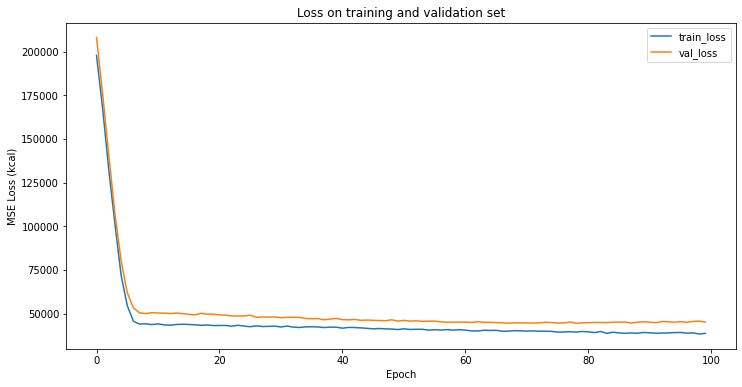

In [6]:
# imagenet preprocessing

import matplotlib.pyplot as plt

history = history.history

plt.figure(figsize=(12,6))
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')

plt.title("Loss on training and validation set")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (kcal)')
plt.legend()